#Flow Visualization Lab



In [ ]:
#@title Student ID { display-mode: "form" }
Name = "Qingyuan Wu" #@param {type:"string"}
Student_Numb = "1007001664" #@param {type:"string"}
Date = "2021-12-04" #@param {type:"date"}

#you can install dependencies right here or in the Intro section

print(Name + '-' + Student_Numb + '-' + Date)

---

## Useful relations and conversion factors:
The Bernoulli Equation:
> $p+\frac{1}{2}\rho v^2 +\rho gh = const$

Incompressible Continuity Equation: 
> $Q=Av=const$

where:
- A = cross-sectional area
- 𝑔 = acceleration due to gravity
- ℎ = relative height
- 𝑝 = static pressure
- 𝑄 = volumetric flow rate
- 𝑣 = velocity
- 𝜌 = density

Conversion factors:
- $1 (GPM)$ (gallon per minute) $=6.31 \times 10^{-5} (m^3/s)$
- $1 (PSI)$ (pounds per square inch) $=6894.7 (pa)$




In [ ]:
#@title Installing dependencies: { display-mode: "form" }
#@markdown Before we begin, we need to download the data and also install the required software/code on the virtual machine. 
#@markdown To do this simply run this cell by clicking on the play bottun on the left. This takes around one minute to complete.
 
#@markdown After this is done, you should see the downloaded data and code in the files view on the left of the window.
 
# oppening up a bash cell and installing required dependencies for PIV code 
%%capture
%%bash
rm -r sample_data
git clone https://github.com/pouya-m/FlowVisLab
cd ./FlowVisLab/
python ./setup.py build_ext --inplace
rm -r build
mv openpiv ../
pip install mpld3==0.5.5
 
# installing gerris for CFD analysis
sudo apt-get update
sudo apt-get install gerris

---

## A) Orifice Comparison Insert
The first insert in this laboratory is the Orifice comparison. There are three nozzle/channel geometries on this insert which all have the same physical open area (throat) but vary in incoming and outgoing wall geometry. A picture of this insert is below. 

The insert consists of (from left to right) a short-radius orifice, a Venturi nozzle and a thin plate orifice . All nozzle varieties can be found in common flow rate meters, where each has distinct advantages and disadvantages.

**the dimensions are in mm and the depth of the channel for all orifices is 5mm.**

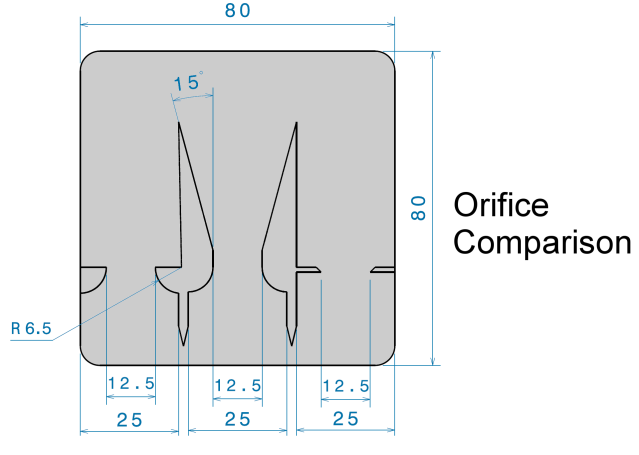

### Step 1: Visualization

(1.a) In the following video, air bubbles were used to make the flow visible. Make a sketch of the flow through all three nozzles drawing [streamlines](https://en.wikipedia.org/wiki/Streamlines,_streaklines,_and_pathlines) and indicating flow direction with arrows. Pay special attention to flow features like [separation](https://en.wikipedia.org/wiki/Flow_separation) and [turbulence](https://en.wikipedia.org/wiki/Turbulence).

(1.b) For each nozzle, comment on how the flow area changes as the water passes through the orifice and mark on the sketch the location of the [vena contracta](https://en.wikipedia.org/wiki/Vena_contracta#:~:text=Vena%20contracta%20is%20the%20point,cross%20section%20area%20is%20minimum.) (smallest area of jet), if it exists for each nozzle.

(1.c) For the thin plate orifice nozzle (the one on the right), estimate the reduction in the area of the jet at the vena contracta compared to the physical throat area. your estimation can be a rough estimate in percentage.

In [ ]:
#@title Orifice comparison video {  display-mode: "form" }
from IPython.display import HTML
print('Link to Youtube: https://youtu.be/NN0LbzISnCI')
print('Link to MyMedia: https://play.library.utoronto.ca/3b8d84080e8cc18a8d7e529d54aa4fe7 \n')

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/NN0LbzISnCI" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Step 1 Questions

a) See image

b) For each nozzle, the flow area is constrained by the orifice. For the left geometry, the free flow area after the throat is smaller than before the throat since there is turbulence at the two side plates. For the middle geometry, the flow area re-grows some distance after the throat due to the gradual expansion of the side plates. For the rightmost geometry, the flow area is constrained the most, again due to turbulence towards the sides.

c) The width of the vena contracta is roughly 70% the width of the throat area.

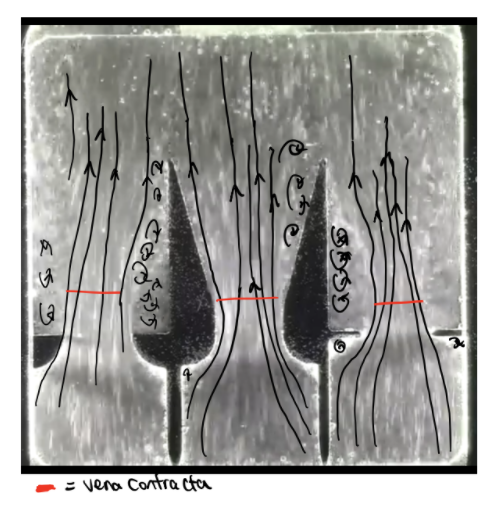

## Step 2



In [ ]:
# form inputs
#@title PIV Analysis Settings: { display-mode: "form" }
region = "Orifice_round" #@param ["Orifice_round", "Orifice_nozzle", "Orifice_flat"]
window_size = 64 #@param {type:"integer"}
overlap = 32 #@param {type:"integer"}
search_area =  80#@param {type:"integer"}
scale =  23.04#@param {type:"number"}
background_removal = "on" #@param ["on", "off"]
bad_vector_replacement = "on" #@param ["on", "off"]
gif_animation = "On" #@param ["On", "Off"]
 
#@markdown Notes:
#@markdown - region: the insert consists of three different orifices. choose of them for the analysis.
#@markdown - window_size (pixels): the size of each interogation window. a value between 20 to 120 is reasonable.
#@markdown - overlap (pixels): the amount of overlap between each interogation window. should be less than 'window_size'. usually this parameter is set to about half the window_size.
#@markdown - search_area (pixels): the size of the area that is searched to find a match for the interogation window. should be equal or larger than the 'window_size'.
#@markdown - scale (pixel/mm): the scale factor between the image and the physical model. 
#@markdown - background_removal: option to remove background and reflections from images before processing. helps to get more accurate results.
#@markdown - bad_vector_replacement: if enabled, the program finds incorrect velocity vectors and replaces them with a vector interpolated from the neighboring vectors.
#@markdown - gif_animation: controls whether an animation is generated as a gif file or not.
 
# importing required libraries
from openpiv import lab, tools
import os, warnings
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt, mpld3
from google.colab import files as fls
 
# setting up some settings for outputs
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 150
 
# setting up the process settings
stg = {}
stg['WS'] = window_size
stg['OL'] = overlap
stg['SA'] = search_area
stg['SC'] = scale
stg['BR'] = background_removal
stg['BVR'] = bad_vector_replacement
stg['DT'] = 0.001094 # time between frame_a and frame_b
stg['DP'] = os.path.join('/content/FlowVisLab/Images', region) # path to the experiment data
stg['MF'] = [2000, 5000]
stg['GF'] = [(-3000,3000),(-3000,10000)]
 
 
#sending the settings to base code for processing
bg = lab.ProcessHandler(stg)
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SavePIVanim(stg['DP'], stg['SC'], bg)
print('- all done.')
 
# GUI related code for the plot
 
def DrawPIVPlot(files, scale, bg):
    # reading saved data and creating vector labels
    x, y, u, v, label = tools.read_data(files)
    label = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            label.append(f'Ux:{u[i, j]:4.2f} , Uy:{v[i, j]:4.2f} (mm/s)')
    # plotting the results
    fig, ax = plt.subplots()
    ax.imshow(bg, cmap='gray', extent=[0., 780/scale, 0., 580/scale])
    q = ax.quiver(x, y, u, -v, color='b', units='xy', minlength=0.1, minshaft=1.2)
    ax.set_title('Velocity Field', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)
    #plt.tight_layout()
 
def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view(os.path.join(stg['DP'], 'Analysis'))
 
 
dt = 0.01486
files = {}
for n in range(0,100,2):
    files[n*dt/2] = os.path.join(stg['DP'], f'Analysis/frame{n:04d}.dat')
 
button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)
 
@widgets.interact(time=(0,49*dt,dt))
def h(time=0):
    DrawPIVPlot(files[time], stg['SC'], bg)

### Step 2: PIV Analysis

(2.a) [PIV](https://en.wikipedia.org/wiki/Particle_image_velocimetry) images were taken from the flow for each orifice at a flow rate of 0.8 GPM. Using the file menu on the left, take a look at these aquired images and choose one of the orifice channels for this analysis. Run the PIV analysis for the chosen section and measure the flow velocity at the physical throat. 

hint: write down the velocity components and their unit and be carefull when calculating the scale factor.

Orifice flat
Velocity at the throat:

Near the centre (x=18, y=7): the average velocity is 269.6mm/s in y, -16.3mm/s in x



In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position = 18 #@param {type:"integer"}
y_position =  7#@param {type:"integer"}
#@markdown Notes:

#@markdown x_position and y_position are the x and y coordinates of the desired point in mm.

from openpiv import tools
import glob

results = sorted(glob.glob(f'/content/FlowVisLab/Images/{region}/Analysis/frame*.dat'))
x, y, *_ = tools.read_data(results[0])
idx = np.abs(x[1,:] - x_position).argmin()
idy = np.abs(y[:,1] - y_position).argmin()
u1 = []
v1 = []
for i in range(len(results)):
    x, y, u, v, mask = tools.read_data(results[i])
    u1.append(u[idy,idx])
    v1.append(v[idy,idx])
print(sum(u1)/len(u1))
print(sum(v1)/len(v1))
time = np.arange(0,50)*dt
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
grabtext = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
#plt.tight_layout()

- **write down your answer here...**
Looking at the average velocity of the Orifice flat geometry, at the centre of the throat.

Near the centre (x=18, y=7): the average velocity is 269.6mm/s in y, -16.3mm/s in x

### Step 3: CFD Simulation

(3.a) Use the [CFD](https://en.wikipedia.org/wiki/Computational_fluid_dynamics) solver below to model the flow through the orifice comparison insert, using a uniform inlet velocity of 120 mm/s and a mesh refinement level of 5. Comment on how well the flow distribution matches the flow visualizations of step 1 and identify possible reasons for any differences.

(3.b) Repeat the CFD solver with a mesh refinement level of 6. Identify the main differences between these results and the results in step 3.a.

In [ ]:
# form parameters
#@title CFD Simulation settings: { display-mode: "form" }
simulation_time = 5 #@param {type:"number"}
mesh_refinement =  6#@param {type:"integer"}
inlet_velocity = 120 #@param {type:"number"}
output_start_time = 2 #@param {type:"number"}
output_time_step = 0.2 #@param {type:"number"}
gif_animation = "On" #@param ["On", "Off"]

#@markdown Notes:
#@markdown - simulation_time (s): the total simulation time in seconds. a value between 3 to 10 seconds is reasonable. for mesh_refinement values higher than 5 keep the simulation_time low (like 3 to 5 sec) so that the simulation does not take too long to complete.
#@markdown - mesh_refinement (dimentionless): mesh refinement level. for example if this value is set to 5, then each axes is divided to 2^5 = 32 sections and the total number of regions to solve in 2D space would be 32*32=1024.
#@markdown - inlet_velocity (mm/s): the velocity at the inlet.
#@markdown - output_start_time (s): the time from which the solver starts to output the results of the simulation. should be less than the simulation_time otherwise no output is generated.
#@markdown - output_time_step (s): the time step between the output files. Note that the simulation time step is automatically selected according to the flow properties and this time step is only for the output files.
#@markdown - gif_animation: controls whether an animation is generated as a gif file or not.
# import required libraries
from openpiv import lab
import numpy as np
import os, warnings
import matplotlib.pyplot as plt, mpld3
from matplotlib.patches import Polygon, Wedge
from matplotlib.collections import PatchCollection
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from google.colab import files as fls
from google.colab import output


# setting up some global settings for plots
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.2, 4)
plt.rcParams['figure.dpi'] = 150

# collecting the settings for simulation
stg = {}
stg['ST'] = simulation_time
stg['MR'] = mesh_refinement
stg['IV'] = inlet_velocity
stg['OST'] = output_start_time
stg['ODT'] = output_time_step

# defining the geometry for plots
h = -27.5
patches = [Wedge((-40,h+13.5), 6.625, -90, 0), Wedge((-14.25,h+13.5), 6.625, 180, 270), \
            Polygon([[-15,h+6.875],[-15,h-1.5],[-13.75,h-6.5],[-12.5,h-1.5],[-12.5,h+13.5],[-14.5,h+13.5]], True),\
            Wedge((-12.5,h+13.5), 6.287, -90, 0), Polygon([[-6.213,h+13.5],[-6.213,h+17.84],[-14.25,h+50.5],[-14.25,h+13.5]], True), \
            Polygon([[6.213,h+13.5],[6.213,h+17.84],[14.5,h+50.5],[14.5,h+13.5]], True), Wedge((12.5,h+13.5), 6.287, 180, 270), \
            Polygon([[14.5,h+6.875],[14.5,h-1.5],[13.5,h-6.5],[12.5,h-1.5],[12.5,h+13.5],[14.5,h+13.5]], True), \
            Polygon([[14.5,h+13.5],[19.5,h+13.5],[20.75,h+12.25],[14.5,h+12.25]], True), \
            Polygon([[33.25,h+12.25],[34.5,h+13.5],[39.5,h+13.5],[39.5,h+12.25]], True)]
p = PatchCollection(patches, alpha=1)

# CFD folder preparation
def StartCFDFolder():
    if os.path.isdir('./CFD'):
        !rm -r ./CFD
    !mkdir ./CFD
    !cp '/content/FlowVisLab/Gerris Files/TripleModel/model.gts' ./CFD


# this function draws the results
def DrawPlot(filename):
    a = np.loadtxt(filename, skiprows=1)
    x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
    label = []
    for i in range(len(x)):
        label.append(f'Ux:{-v[i]:4.2f} , Uy:{u[i]:4.2f} (mm/s)')
    fig, ax = plt.subplots()
    # x and y axes are messed up bc we are plotting and rotating the results CCW at the same time
    cntr = ax.tricontourf(-y, x, pressure, levels=20, cmap='hot', vmin=vmin, vmax=vmax)
    fig.colorbar(cntr, ax=ax, aspect=30, shrink=0.5)
    q = ax.quiver(-y, x, -v, -u, units='xy', color='k', minlength=0.1, minshaft=1.2)
    p = PatchCollection(patches, alpha=1)
    ax.add_collection(p)
    ax.axis([-40, 40, -40, 60])
    ax.set_title('Velocity Field (background color shows pressure)', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    ax.set_xlim(-80,80)
    ax.set_ylim(-40, 60)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)

# function to open the CFD folder
def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view('/content/CFD')

# running the simulation
StartCFDFolder()
lab.WriteGerrisFile('/content/CFD/run.gfs', stg)
print('running the simulation:')
!cd ./CFD && gerris2D /content/CFD/run.gfs
output.clear()
print('----------------------------------------------------')
print('- Done with simulation.')
a = np.loadtxt(f'/content/CFD/output_{simulation_time:.3f}.txt', skiprows=1)
x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
vmin = pressure.min()
vmax = pressure.max()
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SaveCFDanim('/content/CFD', p, vmin=vmin, vmax=vmax)
  print(' - Done with gif')

button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)

# interactive plot
@interact(time1=(output_start_time,simulation_time,output_time_step))
def h(time1=output_start_time):
    DrawPlot(f'/content/CFD/output_{time1:.3f}.txt')

In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position =  18#@param {type:"integer"}
y_position =  7#@param {type:"integer"}
#@markdown Notes:
#@markdown - x_position and y_position are the x and y coordinates of the desired point in mm.

import glob

def find_nearest(x, y, xvalue, yvalue):
    r = x.copy()
    for i in range(len(x)):
        r[i] = (x[i]-xvalue)*(x[i]-xvalue) + (y[i]-yvalue)*(y[i]-yvalue)
    ind = r.argmin()
    return ind

results = sorted(glob.glob('/content/CFD/output_*.txt'))
a= np.loadtxt(results[0], skiprows=1)
x, y = a[:,0] , a[:,1]
ind = find_nearest(x, y, y_position, -1*x_position)
u1 = []
v1 = []
for i in range(len(results)):
    a = np.loadtxt(results[i], skiprows=1)
    u1.append(-a[ind,4])
    v1.append(a[ind,3])

time = np.arange(output_start_time,simulation_time+(output_time_step/2.0),output_time_step)
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
_ = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
#plt.tight_layout()

- **write down your answer here...**

a) The CFD solver's model of the velocity field is different from the actual flow for the rightmost geometry (orifice flat). For the CFD model it seemed like the two plates constraining the flow at the throat area were not considered - the fluid merely flowed through the plates as if they were not there. This is because the mesh was too coarse and the barriers were "skipped over".

One difference between the CFD solver and the video was that the video showed the pathlines between the left and middle orfices converging quicker than in the CFD simulation. This was likely due to the discretization method that the CFD uses to model flow - using a 0.2s time step meant that the direction change of the velocity vectors (converging towards the middle) could not be well modelled and the flow appeared straighter than actual flow. Another reason with the CFD's error could be due to the large mesh sizes at regions of turbulence and direction change. CFD discretizes a region of space to a single mesh, which leads to errors in the flow direction at regions where In general we want to use a finer mesh where there is a large change in fluid velocity, such as on the boundary layer. However, this CFD simulation uses a uniform, relatively large mesh size. The space discretization could also be the reason why the no-slip condition was not observed near the throat of the middle geometry - the boundary layer did not have a fine enough mesh to correctly model the no slip condition.

Velocity at x=18, y=7: 140 mm/s in y, 0 mm/s in x.

b) with a mesh refinement of 6 instead of 5, most of the issues pointed out in part a) were resolved. First, the CFD results modelled the flow through the right-most geometry's throat very well - the flow obeyed the throat's constraints and velocity decreased. The finer mesh was also able to predict turbulence better - turbulence near the top-right was correctly predicted.

### Step 4: Comparison

(4.a) Each of these three nozzles represent geometries used in real flowrate meters. For each nozzle list one possible advantage and one disadvantage for using it in a real flow system.

hint: don't limit your thinking to what you have seen in the lab. think of efficiency and energy losses, ease of production, cost and ...

- **write down your answer here...**

4a) comparison between the geometries

Flat (right)

Advantage: easy to manufacture (there is no curved parts which is more costly to design and machine).

Disadvantage: 

Significant turbulence after the throat. In general turbulence is undesidrable as it results in much more energy loss in the system and adds unpredictability.

Nozzle (middle)

Advantage:

This flow metre has the least turbulence after the throat because of the gradual widening of the channel.

Disadvantage:

The curved section is difficult to manufacture. One also has to pay special attention in ensuring the boundary's smoothness to limit turbulence. It is more difficult and costly to smooth out a curved surface (through sanding) than a straight surface.


Round (left)

Advantage:

This geometry effectively limits turbulence of the incoming flow with the round geometry. It is a nice compromise between the flat and nozzle geometries, decreasing cost while eliminating turbulence before the throat

Disadvantage:

There is still turbulence after the throat so some energy lost is present.



---

## B) Venturi Insert
The Venturi insert provides an example of how the flow rate in a pipe can be measured by means of the pressure difference induced by a smooth contraction. Typical Venturi meters have only slight contractions to minimize pressure losses, but our model has been designed to make the flow variations as large as possible for laboratory measurements.

A picture of this insert can be seen below. There are 2 holes in the insert for pressure measurements. One in the flow inlet (bottom of the insert) and one at the throat. As depicted in the picture the distance between these points is 50 mm.


**again, the dimensions are in mm and the depth of the channel is 5mm.**
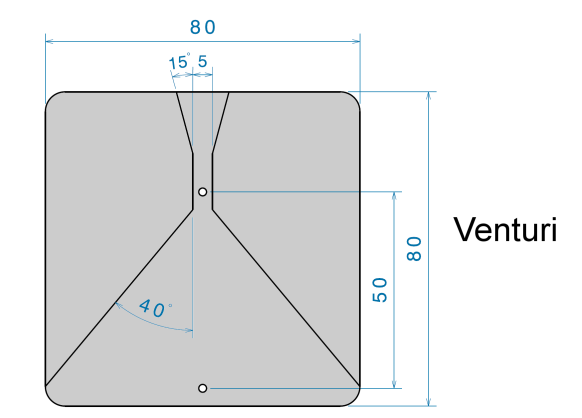

### Step 1: Theoretical Formulation
(1.a) For a Venturi, the pressure difference between the inlet and the throat (Δp = p1 – p2) varies as a function of the volume flow rate (Q). Using the Bernoulli equation and the Conservation of Mass (Continuity) equation, determine the dependency between these parameters.

(1.b) For a flow rate of 0.8 GPM and one other flow rate between 0.9 and 1.7 GPM (each student should choose a different flow rate), calculate the analytical pressure difference between the inlet and the throat for the Venturi meter insert.

- **write down your answer here...**

Bernoulli's Equation:

> $P_1 + \frac{\rho v_1^2}{2}+ \rho gh_1 = P_2 + \frac{\rho v_2^2}{2}+ \rho gh_2$

Setting $h_1 = h_2$, the equation simplies to:

> $P_1 + \frac{\rho v_1^2}{2} = P_2 + \frac{\rho v_2^2}{2}$

> $\Delta P = P_2 - P_1 = \frac{\rho}{2}(v_1^2-v_2^2)$

Also the continuity equation:

> $Q = A_1v_1=A_2v_2$

Combining the two equations:

> $\Delta P = \frac{\rho Q^2}{2}(\frac{1}{A_1^2}-\frac{1}{A_2^2})$

For the venturi:

$A_1 = (80mm)(5mm)=0.0004m^2, A_2 = (5mm)(5mm)=0.000025m^2, \rho_{water} = 1000 kg/m^3$

b) For $Q=0.8 GPM = 5.05\cdot 10^{-5} m^3/s$

>$\Delta P = \frac{1000kg/m^3 (5.05\cdot 10^{-5}m^3/s)^2}{2}(\frac{1}{(0.0004m^2)^2}-\frac{1}{(0.000025m^2)^2}) \dot= -2030 Pa=0.294 PSI$

For $Q = 1.0 GPM = 6.31\cdot 10^{-5} m^3/s$

> $\Delta P = \frac{1000kg/m^3 (6.31\cdot 10^{-5}m^3/s)^2}{2}(\frac{1}{(0.0004m^2)^2}-\frac{1}{(0.000025m^2)^2}) \dot= -3172 Pa = 0.460 PSI$

### Step 2: Pressure Measurement
As mentioned earlier, there are two probes in the venturi insert to measure the differential pressure between the inlet flow and at the throat. Measurements for Δp as a function of volume flow rate for a range of flow rates between 0.8 and 1.8 gallons per minute (GPM) are given below.

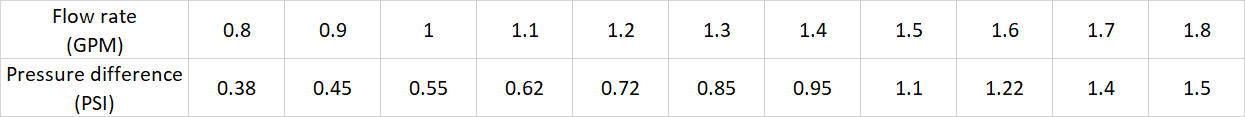

(2.a) Plot these experimental results on a graph in SI units (you can either draw a sketch by hand or plot it in an excel sheet and attach it below).

(2.b) Are the experimental data consistent with the expected dependence and the analytical Δp values calculated in step 1?

(2.c) Identify any possible causes for errors between the measured and analytical values

hint: think about the bernouli equation and its' assumptions.

- **write down your answer here...**

a) See attached Excel graph.

b) There are some differences between the theoretical and measured values. The theoretical pressure drop at Q=0.8 GPM differed from the measured value by 0.086 psi, leading to a percentage error of 23% from the measured pressure difference. At Q=1.0 GPM, the theoretical pressure drop was 0.46 psi vs. the actual pressure drop of 0.55 psi. This equates to an error of 16%. The experimental pressure vs. flow rate data follows the general trend as Bernoulli's equation, but the exact values at each Q differ beyond uncertainties.

c) Bernoulli's equation assumes steady flow, which is not a good approximation here but not entirely inaccurate. For our physical flow the velocity and streamlines do change with time. However at regions where there is no turbulence (which is the region of interest here), the flow can be modelled as steady. Also, Bernoulli's equation is only valid along a streamline, so here we are assuming that points 1 and 2 line on the same streamline.

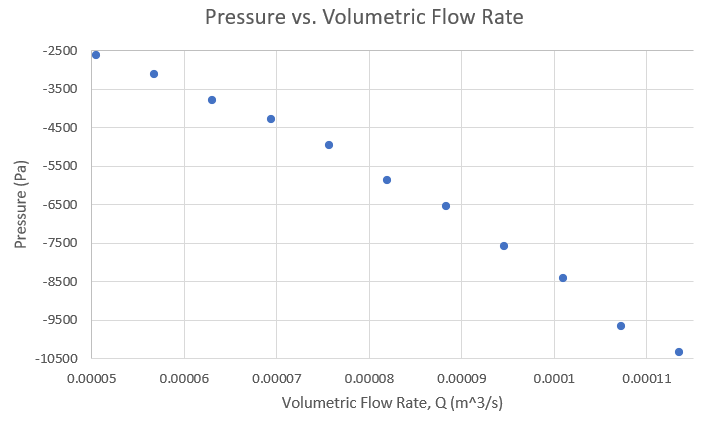

### Step 3: Sketching the Flow
(3.a) In the video below air bubbles were used to make the flow visible. sketch the flow field in the Venturi insert. Again, using lines and arrows to show the main flow properties.

(3.b) Is the flow through the Venturi insert [steady or unsteady](https://en.wikipedia.org/wiki/Fluid_dynamics#Steady_vs_unsteady_flow)? Is this expected?

- **write down your answer here...**

a) see image below

b) The flow through the venturi insert is steady before and through the throat. A significant portion of the flow (the right hand side) becomes unsteady after the throat. This is expected.

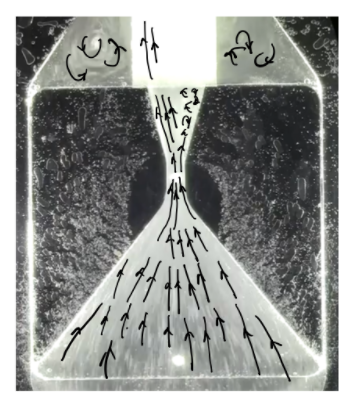

### Step 4: CFD Simulations
(4.a) Run the CFD solver below using the inlet conditions calculated for 0.8 GPM flow rate(having the flow rate and the cross section area, calculate the velocity at the inlet - hint: inlet_velocity = 120 mm/s). Sketch the calculated flow field and write down the average velocity at the Venturi throat.

(4.b) Describe any differences found between the CFD and the visualizations. Was the [flow turbulence](https://en.wikipedia.org/wiki/Turbulence) modeled acurately in the simulation? how about separation points?

In [ ]:
# form parameters
#@title CFD Simulation settings: { display-mode: "form" }
simulation_time = 4 #@param {type:"number"}
mesh_refinement = 4 #@param {type:"integer"}
inlet_velocity = 120 #@param {type:"number"}
output_start_time = 2 #@param {type:"number"}
output_time_step =  0.2 #@param {type:"number"}
gif_animation = "On" #@param ["On", "Off"]

#@markdown Notes:
#@markdown - simulation_time (s): the total simulation time in seconds. a value between 3 to 10 seconds is reasonable. for mesh_refinement values higher than 5 keep the simulation_time low (like 3 to 5 sec) so that the simulation does not take too long to complete.
#@markdown - mesh_refinement (dimentionless): mesh refinement level. for example if this value is set to 5, then each axes is divided to 2^5 = 32 sections and the total number of regions to solve in 2D space would be 32*32=1024.
#@markdown - inlet_velocity (mm/s): the velocity at the inlet.
#@markdown - output_start_time (s): the time from which the solver starts to output the results of the simulation. should be less than the simulation_time otherwise no output is generated.
#@markdown - output_time_step (s): the time step between the output files. Note that the simulation time step is automatically selected according to the flow properties and this time step is only for the output files.
#@markdown - gif_animation: controls wether an animation is generated as a gif file or not.

# import required libraries
from openpiv import lab
import numpy as np
import os, warnings
import matplotlib.pyplot as plt, mpld3
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from google.colab import files as fls
from google.colab import output

# setting up some global settings for plots
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.2, 4)
plt.rcParams['figure.dpi'] = 150

# collecting the settings for simulation
stg = {}
stg['ST'] = simulation_time
stg['MR'] = mesh_refinement
stg['IV'] = inlet_velocity
stg['OST'] = output_start_time
stg['ODT'] = output_time_step

# defining the geometry for plots
patches = [Polygon([[-40,-35],[-40,40],[-6.7,40],[-2.5,24.3],[-2.5,10]], True), \
        Polygon([[40,-35],[40,40],[6.7,40],[2.5,24.3],[2.5,10]], True)]
p = PatchCollection(patches, alpha=0.8)

# CFD folder preparation
def StartCFDFolder():
    if os.path.isdir('./CFD'):
        !rm -r ./CFD
    !mkdir ./CFD
    !cp '/content/FlowVisLab/Gerris Files/Venturi/model.gts' ./CFD

# this function draws the results
def DrawPlot(filename):
    a = np.loadtxt(filename, skiprows=1)
    x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
    label = []
    for i in range(len(x)):
        label.append(f'Ux:{-v[i]:4.2f} , Uy:{u[i]:4.2f} (mm/s)')
    fig, ax = plt.subplots()
    # x and y axes are messed up bc we are plotting and rotating the results CCW at the same time
    cntr = ax.tricontourf(-y, x, pressure, cmap='hot', levels=20, vmin=vmin, vmax=vmax)
    fig.colorbar(cntr, ax=ax, aspect=30, shrink=0.5)
    q = ax.quiver(-y, x, -v, -u, units='xy', color='k', minlength=0.1, minshaft=1.2)
    p = PatchCollection(patches, alpha=1)
    ax.add_collection(p)
    ax.axis([-40, 40, -40, 120])
    ax.set_title('Velocity Field (background color shows pressure)', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    ax.set_xlim(-80,80)
    ax.set_ylim(-40,100)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)

# function to show the CFD folder
def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view('/content/CFD')

# running the simulation
StartCFDFolder()
lab.WriteGerrisFile('/content/CFD/run.gfs', stg)
print('running the simulation:')
!cd ./CFD && gerris2D /content/CFD/run.gfs
output.clear()
print('----------------------------------------------------')
print('- Done with simulation.')
a = np.loadtxt(f'/content/CFD/output_{simulation_time:.3f}.txt', skiprows=1)
x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
vmin = pressure.min()
vmax = pressure.max()
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SaveCFDanim('/content/CFD', p, vmin=vmin, vmax=vmax)
  print(' - Done with gif')

button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)

# interactive plot
@interact(time1=(output_start_time,simulation_time,output_time_step))
def h(time1=output_start_time):
    DrawPlot(f'/content/CFD/output_{time1:.3f}.txt')

In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position = 0 #@param {type:"integer"}
y_position =  15#@param {type:"integer"}
#@markdown Notes:
#@markdown - x_position and y_position are the x and y coordinates of the desired point in mm.

import glob

def find_nearest(x, y, xvalue, yvalue):
    r = x.copy()
    for i in range(len(x)):
        r[i] = (x[i]-xvalue)*(x[i]-xvalue) + (y[i]-yvalue)*(y[i]-yvalue)
    ind = r.argmin()
    return ind

results = sorted(glob.glob('/content/CFD/output_*.txt'))
a= np.loadtxt(results[0], skiprows=1)
x, y = a[:,0] , a[:,1]
ind = find_nearest(x, y, y_position, -1*x_position)
u1 = []
v1 = []
for i in range(len(results)):
    a = np.loadtxt(results[i], skiprows=1)
    u1.append(-a[ind,4])
    v1.append(a[ind,3])
print(u1)
print(v1)
time = np.arange(output_start_time,simulation_time+(output_time_step/2),output_time_step)
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
_ = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
#plt.tight_layout()

- **write down your answer here...**

a) see attached image. Average velocity at throat: 400 mm/s in the x direction, 1959 mm/s in the y direction.

b) The flow before the throat was modelled accurately. However, the CFD failed to predict the turbulence after the throat in the gradually widening region. The CFD model also predicted streamlines of flow to cross each other (slightly after the throat). This does not happen in the real flow. The CFD model did not predict the separation at the throat widening region.

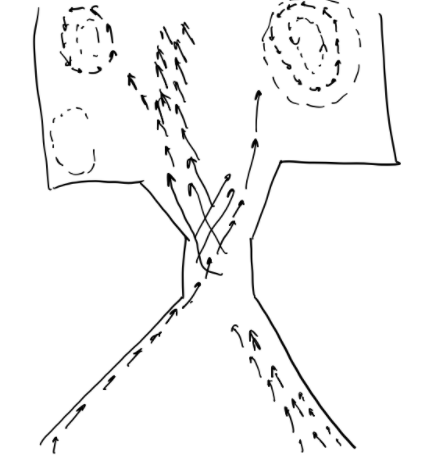

### Step 5: PIV Measurements
(5.a) PIV images were taken for a flow rate of 0.8 GPM. Use the file menu on the right to look at the pictures. run the PIV analysis below and measure the velocity at the throat.

(5.b) Compare the measured velocities from PIV with the velocities derived from the Bernoulli and Continuity equations, and the CFD results. Do these result agree? What is the cause for differences if any? and what can be done to improve them?

hint: The combination of high flow velocity at the throat and camera limitations in taking high speed pictures result in poor quality (blurry) pictures at the throat, therefore PIV measurements are not accurate. this is a reminder that if you cannot get good quality pictures from the flow, then PIV analysis will fail to produce reliable results. You can discuss this and other limitations for each method in your answers.

In [ ]:
# form inputs
#@title PIV Analysis Settings: { display-mode: "form" }
window_size =  64#@param {type:"integer"}
overlap =  32#@param {type:"integer"}
search_area =  80#@param {type:"integer"}
scale =  18.2#@param {type:"number"}
background_removal = "on" #@param ["on", "off"]
bad_vector_replacement = "on" #@param ["on", "off"]
gif_animation = "On" #@param ["On", "Off"]

#@markdown Notes:
#@markdown - region: the insert consists of three different orifices. choose of them for the analysis.
#@markdown - window_size (pixels): the size of each interogation window. a value between 20 to 120 is reasonable.
#@markdown - overlap (pixels): the amount of overlap between each interogation window. should be less than 'window_size'. usually this parameter is set to about half the window_size.
#@markdown - search_area (pixels): the size of the area that is searched to find a match for the interogation window. should be equal or larger than the 'window_size'.
#@markdown - scale (pixel/mm): the scale factor between the image and the physical model. 
#@markdown - background_removal: option to remove background and reflections from images before processing. helps to get more accurate results.
#@markdown - bad_vector_replacement: if enabled, the program finds incorrect velocity vectors and replaces them with a vector interpolated from the neighboring vectors.
#@markdown - gif_animation: controls whether an animation is generated as a gif file or not.

# importing required libraries
from openpiv import lab, tools
import os, warnings
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt, mpld3
from google.colab import files as fls

# setting up some settings for outputs
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 150

# setting up the process settings
stg = {}
stg['WS'] = window_size
stg['OL'] = overlap
stg['SA'] = search_area
stg['SC'] = scale
stg['BR'] = background_removal
stg['BVR'] = bad_vector_replacement
stg['DT'] = 0.001094 # time between frame_a and frame_b
stg['DP'] = os.path.join('/content/FlowVisLab/Images', 'Venturi') # path to the experiment data
stg['MF'] = [8000,15000]
stg['GF'] = [(-10000,10000),(-1000,20000)]


#sending the settings to base code for processing
bg = lab.ProcessHandler(stg)
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SavePIVanim(stg['DP'], stg['SC'], bg)
print('- all done.')

# GUI related code for the plot

def DrawPIVPlot(files, scale, bg):
    # reading saved data and creating vector labels
    x, y, u, v, label = tools.read_data(files)
    label = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            label.append(f'Ux:{u[i, j]:4.2f} , Uy:{v[i, j]:4.2f} (mm/s)')
    # plotting the results
    fig, ax = plt.subplots()
    ax.imshow(bg, cmap='gray', extent=[0., 780/scale, 0., 580/scale])
    q = ax.quiver(x, y, u, -v, color='b', units='xy', minlength=0.1, minshaft=1.2)
    ax.set_title('Velocity Field', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)
    #plt.tight_layout()

def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view(os.path.join(stg['DP'], 'Analysis'))


dt = 0.01486
files = {}
for n in range(0,100,2):
    files[n*dt/2] = os.path.join(stg['DP'], f'Analysis/frame{n:04d}.dat')

button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)

@widgets.interact(time=(0,49*dt,dt))
def h(time=0):
    DrawPIVPlot(files[time], stg['SC'], bg)

In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position =  23#@param {type:"integer"}
y_position =  32#@param {type:"integer"}
#@markdown Notes:

#@markdown x_position and y_position are the x and y coordinates of the desired point in mm.

from openpiv import tools
import glob

results = sorted(glob.glob(f'/content/FlowVisLab/Images/Venturi/Analysis/frame*.dat'))
x, y, *_ = tools.read_data(results[0])
idx = np.abs(x[1,:] - x_position).argmin()
idy = np.abs(y[:,1] - y_position).argmin()
u1 = []
v1 = []
for i in range(len(results)):
    x, y, u, v, mask = tools.read_data(results[i])
    u1.append(u[idy,idx])
    v1.append(v[idy,idx])

print(sum(u1)/len(u1))
print(sum(v1)/len(v1))
time = np.arange(0,50)*dt
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
grabtext = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
#plt.tight_layout()

- **write down your answer here...**
PIV:

Velocity at x = 23 mm, y = 32 mm:

x-component: 10.0 mm/s, y-component: 23.9 mm/s

Use the continuity equation to find velocity:

$A_1v_1 = A_2v_2 \implies v_2 = v_1 A_1/A_2$
$A_1/A_2 = 80/5 = 16$
$v_2 = 120(16) = 1920 mm/s$

The throat velocity value obtained from the continuity equation and the one obtained from CFD were very similar. However the velocity value obtained from PIV was much smaller. This is because accurate pictures cannot be taken at high velocities - the particles become blurry and velocity cannot be determined accurately using the PIV method. Also, the velocity value obtained from the continuity equation did not have an x-component because we assumed the flow to be perfectly vertical.

---

## C) Square Insert
This insert consists of a simple square body. It provides an example of a complex flow field created around a bluff, or non-streamlined body.
A picture is attached below.

**Again, the dimentions are in mm.**

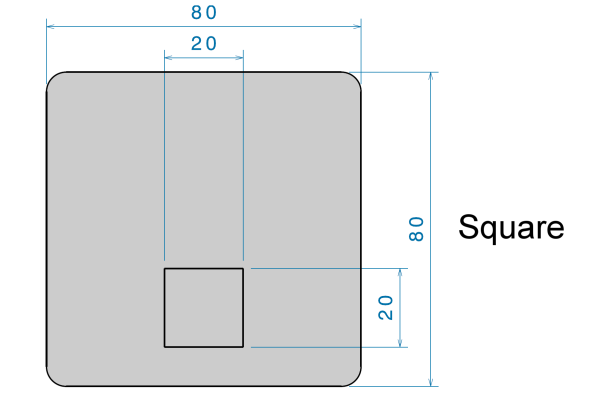

### Step 1: Visualization
(1.a) In the video below, air bubbles were used to make the flow pattern visible. Sketch the flow pattern around the square insert.

(1.b) Comment on the main flow features observable around the entire square insert and highlight these features on your sketch. How do these features vary with flow rate?

- **write down your answer here...**

Some major flow features are the wake (region of turbulence behind the square insert) and the stagnation point (point of zero velocity directly in front of the square). The wake region has little eddies that run in circles. The stagnation point sees streams splitting left and right.

As the flow rate increases, the wake region becomes larger and more unstable. It wobbles left and right. 

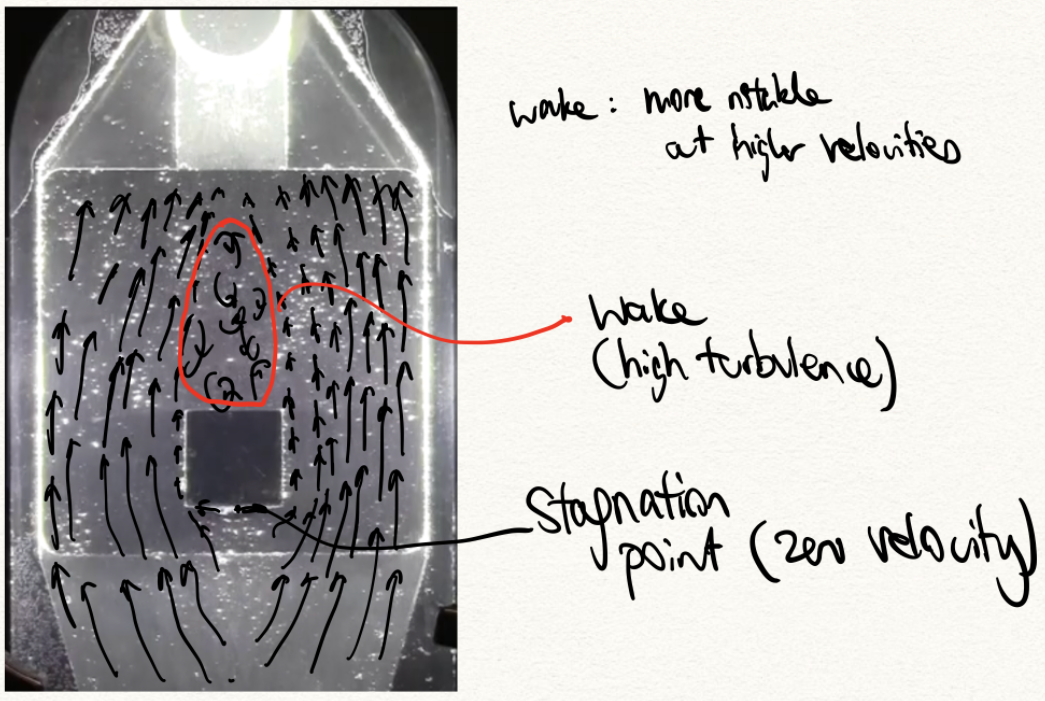

### Step 2: PIV Analysis

(2.a) PIV images were taken from the flow at a flow rate of 0.8 GPM. There are two image sets. One focuses on the flow on the side of the square while the other shows the flow behind the it ([wake flow](https://en.wikipedia.org/wiki/Wake), [vortex street](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street)).Using the file menu look at the pictures and use the PIV analysis tool below to find the location of the maximum and minimum flow velocities around the square.Indicate their locations and approximate values. 
(hint: velocity consists of both x and y-direction components. the volicity hits its' maximum or minimum when the sum of these component reaches the extrema)

In [ ]:
# form inputs
#@title PIV Analysis Settings: { display-mode: "form" }
region = "Square_wake" #@param ["Square_side", "Square_wake"]
window_size = 64 #@param {type:"integer"}
overlap = 32 #@param {type:"integer"}
search_area =  80#@param {type:"integer"}
scale = 18.35 #@param {type:"number"}
background_removal = "on" #@param ["on", "off"]
bad_vector_replacement = "on" #@param ["on", "off"]
gif_animation = "On" #@param ["On", "Off"]

#@markdown Notes:
#@markdown - region: there are two image sets, one shows the side and the other shows the flow behind the square. choose one of them for analysis.
#@markdown - window_size (pixels): the size of each interogation window. a value between 20 to 120 is reasonable.
#@markdown - overlap (pixels): the amount of overlap between each interogation window. should be less than 'window_size'. usually this parameter is set to about half the window_size.
#@markdown - search_area (pixels): the size of the area that is searched to find a match for the interogation window. should be equal or larger than the 'window_size'.
#@markdown - scale (pixel/mm): the scale factor between the image and the physical model. 
#@markdown - background_removal: option to remove background and reflections from images before processing. helps to get more accurate results.
#@markdown - bad_vector_replacement: if enabled, the program finds incorrect velocity vectors and replaces them with a vector interpolated from the neighboring vectors.
#@markdown - gif_animation: controls whether an animation is generated as a gif file or not.

# importing required libraries
from openpiv import lab, tools
import os, warnings
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt, mpld3
from google.colab import files as fls

# setting up some settings for outputs
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 150

# setting up the process settings
stg = {}
stg['WS'] = window_size
stg['OL'] = overlap
stg['SA'] = search_area
stg['SC'] = scale
stg['BR'] = background_removal
stg['BVR'] = bad_vector_replacement
stg['DT'] = 0.003094 # time between frame_a and frame_b
stg['DP'] = os.path.join('/content/FlowVisLab/Images', region) # path to the experiment data
stg['MF'] = [2000, 5000]
stg['GF'] = [(-3000,3000),(-3000,10000)]


#sending the settings to base code for processing
bg = lab.ProcessHandler(stg)
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SavePIVanim(stg['DP'], stg['SC'], bg)
print('- all done.')

# GUI related code for the plot

def DrawPIVPlot(files, scale, bg):
    # reading saved data and creating vector labels
    x, y, u, v, label = tools.read_data(files)
    label = []
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            label.append(f'Ux:{u[i, j]:4.2f} , Uy:{v[i, j]:4.2f} (mm/s)')
    # plotting the results
    fig, ax = plt.subplots()
    ax.imshow(bg, cmap='gray', extent=[0., 780/scale, 0., 580/scale])
    q = ax.quiver(x, y, u, -v, color='b', units='xy', minlength=0.1, minshaft=1.2)
    ax.set_title('Velocity Field', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)
    #plt.tight_layout()

def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view(os.path.join(stg['DP'], 'Analysis'))


dt = 0.01486
files = {}
for n in range(0,100,2):
    files[n*dt/2] = os.path.join(stg['DP'], f'Analysis/frame{n:04d}.dat')

button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)

@widgets.interact(time=(0,49*dt,dt))
def h(time=0):
    DrawPIVPlot(files[time], stg['SC'], bg)

In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position =  28#@param {type:"integer"}
y_position =  24#@param {type:"integer"}
#@markdown Notes:

#@markdown x_position and y_position are the x and y coordinates of the desired point in mm.

from openpiv import tools
import glob

results = sorted(glob.glob(f'/content/FlowVisLab/Images/{region}/Analysis/frame*.dat'))
x, y, *_ = tools.read_data(results[0])
idx = np.abs(x[1,:] - x_position).argmin()
idy = np.abs(y[:,1] - y_position).argmin()
u1 = []
v1 = []
for i in range(len(results)):
    x, y, u, v, mask = tools.read_data(results[i])
    u1.append(u[idy,idx])
    v1.append(v[idy,idx])
print(sum(u1)/len(u1))
print(sum(v1)/len(v1))
time = np.arange(0,50)*dt
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
grabtext = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
#plt.tight_layout()

- **write down your answer here...**

Maximum velocity occurs at x=1mm, y=30mm. The velocity here has an average x-component of 23mm/s, and an average y-component of 90mm/s. The total velocity magnitude is 93mm/s

Minimum velocity occurs at x=28mm, y=24mm. The velocity here has an average x-component of-4.7mm/s, and an average y-component of 5.7mm/s. The total velocity magnitude is 7.4mm/s.

### Step 3: CFD Simulation

(3.a) Use the CFD solver below to model the flow around the square. Comment on how well does the simulation capture the complex aspects of the flow and indicate the main differences between the visualization (step 1) and the simulation.

(3.b) Run the simulation with the following settings:

- simulation time: 10, mesh_refinement: 5, inlet_velocity: 120, 

- output_start_time: 5, output_time_step: 0.05, gif_animation: Off

then use the next cell to plot the velocity at point (x,y)=(-10,20). looking at the velocity plot, what is the frequency at which the Ux and Uy velocities are oscillating? calculate the Strouhal number (st=fD/v), does this value correspond to the one mentioned [here](https://en.wikipedia.org/wiki/Vortex_shedding)?



In [ ]:
# form parameters
#@title CFD Simulation settings: { display-mode: "form" }
simulation_time = 10 #@param {type:"number"}
mesh_refinement = 5 #@param {type:"integer"}
inlet_velocity = 120 #@param {type:"number"}
output_start_time = 5 #@param {type:"number"}
output_time_step = 0.05 #@param {type:"number"}
gif_animation = "Off" #@param ["On", "Off"]
 
#@markdown Notes:
#@markdown - simulation_time (s): the total simulation time in seconds. a value between 3 to 10 seconds is reasonable. for mesh_refinement values higher than 5 keep the simulation_time low (like 3 to 5 sec) so that the simulation does not take too long to complete.
#@markdown - mesh_refinement (dimentionless): mesh refinement level. for example if this value is set to 5, then each axes is divided to 2^5 = 32 sections and the total number of regions to solve in 2D space would be 32*32=1024.
#@markdown - inlet_velocity (mm/s): the velocity at the inlet.
#@markdown - output_start_time (s): the time from which the solver starts to output the results of the simulation. should be less than the simulation_time otherwise no output is generated.
#@markdown - output_time_step (s): the time step between the output files. Note that the simulation time step is automatically selected according to the flow properties and this time step is only for the output files.
#@markdown - gif_animation: controls whether an animation is generated as a gif file or not.
 
# import required libraries
from openpiv import lab
import numpy as np
import os, warnings
import matplotlib.pyplot as plt, mpld3
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from google.colab import files as fls
from google.colab import output
 
# setting up some global settings for plots
warnings.filterwarnings("ignore")
mpld3.enable_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.2, 4)
plt.rcParams['figure.dpi'] = 150
 
# collecting the settings for simulation
stg = {}
stg['ST'] = simulation_time
stg['MR'] = mesh_refinement
stg['IV'] = inlet_velocity
stg['OST'] = output_start_time
stg['ODT'] = output_time_step
 
# defining the geometry for plots
patches = [Polygon([[-10,-10],[-10,10],[10,10],[10,-10]], True)]
p = PatchCollection(patches, alpha=1)
 
# CFD folder preparation
def StartCFDFolder():
    if os.path.isdir('./CFD'):
        !rm -r ./CFD
    !mkdir ./CFD
    !cp '/content/FlowVisLab/Gerris Files/Square/model.gts' ./CFD
 
# this function draws the results
def DrawPlot(filename):
    a = np.loadtxt(filename, skiprows=1)
    x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
    label = []
    for i in range(len(x)):
        label.append(f'Ux:{-v[i]:4.2f} , Uy:{u[i]:4.2f} (mm/s)')
    fig, ax = plt.subplots()
    # x and y axes are messed up bc we are plotting and rotating the results CCW at the same time
    cntr = ax.tricontourf(-y, x, pressure, cmap='hot', levels=20, vmin=vmin, vmax=vmax)
    fig.colorbar(cntr, ax=ax, aspect=30, shrink=0.5)
    q = ax.quiver(-y, x, -v, -u, units='xy', color='k', minlength=0.1, minshaft=1.2)
    p = PatchCollection(patches, alpha=1)
    ax.add_collection(p)
    ax.axis([-40, 40, -40, 100])
    ax.set_title('Velocity Field (background color shows pressure)', size=16)
    ax.set_xlabel('x (mm)', size=14, labelpad=2)
    ax.set_ylabel('y (mm)', size=14, labelpad=-10)
    ax.set_xlim(-70,70)
    ax.set_ylim(-20,80)
    tooltip = mpld3.plugins.PointLabelTooltip(q, labels=label, location='bottom left', voffset=50)
    mpld3.plugins.connect(fig, tooltip)
 
# function to show the CFD folder
def ShowGifFolder(b):
    #fls.download(os.path.join(stg['DP'], 'Analysis/result.gif'))
    fls.view('/content/CFD')
 
# running the simulation
StartCFDFolder()
lab.WriteGerrisFile('/content/CFD/run.gfs', stg)
print('running the simulation:')
!cd ./CFD && gerris2D /content/CFD/run.gfs
output.clear()
print('----------------------------------------------------')
print('- Done with simulation.')
a = np.loadtxt(f'/content/CFD/output_{simulation_time:.3f}.txt', skiprows=1)
x, y, u, v, pressure = a[:,0], a[:,1], a[:,3], a[:,4], a[:,5]
vmin = pressure.min()
vmax = pressure.max()
if gif_animation == 'On':
  print('creating gif animation...')
  lab.SaveCFDanim('/content/CFD', p, vmin=vmin, vmax=vmax)
  print('- Done with gif')
 
button = widgets.Button(description="Analysis Folder")
button.on_click(ShowGifFolder)
output = widgets.Output()
display(button, output)
 
# interactive plot
@interact(time1=(output_start_time,simulation_time,output_time_step))
def h(time1=output_start_time):
    DrawPlot(f'/content/CFD/output_{time1:.3f}.txt')

In [ ]:
# form inputs
#@title Plot velocity vs time at a specific point: { display-mode: "form" }
x_position =  -10#@param {type:"integer"}
y_position = 20 #@param {type:"integer"}
#@markdown Notes:
#@markdown - x_position and y_position are the x and y coordinates of the desired point in mm.
 
import glob
 
def find_nearest(x, y, xvalue, yvalue):
    r = x.copy()
    for i in range(len(x)):
        r[i] = (x[i]-xvalue)*(x[i]-xvalue) + (y[i]-yvalue)*(y[i]-yvalue)
    ind = r.argmin()
    return ind
 
results = sorted(glob.glob('/content/CFD/output_*.txt'))
a= np.loadtxt(results[0], skiprows=1)
x, y = a[:,0] , a[:,1]
ind = find_nearest(x, y, y_position, -1*x_position)
u1 = []
v1 = []
for i in range(len(results)):
    a = np.loadtxt(results[i], skiprows=1)
    u1.append(-a[ind,4])
    v1.append(a[ind,3])
 
print(u1)
print(v1)

time = np.arange(output_start_time,simulation_time+(output_time_step/2),output_time_step)
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
l1, = ax.plot(time, u1)
l2, = ax.plot(time, v1)
ax.set_title('Velocity vs time', size=16)
ax.legend((l1, l2), ('Ux', 'Uy'))
plt.xlabel('time(s)', size=14, labelpad=2)
_ = plt.ylabel('velocity(mm/s)', size=14, labelpad=-10)
plt.tight_layout()

- **write down your answer here...**

The CFD does not accurately predict the flow as it shows that the overall flow direction (outside the wake) varies over time. However, in the video, only the wake region exhibited unsteady behaviour, and the flow outside of the wake was steady.

The CFD model captures the flow near the stagnation point relatively well as it shows that there is a region of low velocity and the flow splits left and right near the stagnation point.

b) Calculate the frequency
$f = 1/T = 1/0.85s = 1.18 Hz$
$St = \frac{fD}{V} = \frac{1.18Hz*0.02m}{0.120m/s} = 0.196$

The expected Strouhal number is 0.18-0.22. The calculated St is within the expected range.